# 1) Load packages and data set

In [1]:
#!pip install git+https://github.com/forrestbao/pyeeg.git
#!pip install eeglib
#!pip install pymrmre

import numpy as np
import pandas as pd
import os
import glob
import pickle
import matplotlib.pyplot as plt
import pyeeg
import scipy
import eeglib
import math
import sklearn

from pymrmre import mrmr
from tqdm import trange
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.svm import SVC

In [2]:
# Dataset path

DEAP = "DEAP/data_preprocessed_python/"

<blockquote>For each of the 32 patients, there are a total of 40 stimuli tests. Each patient reports a valence and arousal value between 0 an 9. These are used to create our labels (0, 1, or 2). The data is currently composed of 32-channel EEG recordings.</blockquote>
<blockquote>Note: DEAP provides pre-processed EEG signals. This pre-processing includes downsampling, EOG removal, filtering, segmenting etc... For more information, consult the following link http://www.eecs.qmul.ac.uk/mmv/datasets/deap/readme.html </blockquote>

In [3]:
# Import of the data
labels = np.zeros((32 * 40, 3), dtype=int)
data   = np.zeros((32 * 40, 32, 8064))

for filename in glob.glob('DEAP/data_preprocessed_python/*.dat'):
    print(filename)
    with open(os.path.join(os.getcwd(), filename), 'rb') as f:
        
        # Open file using latin1 encoding
        x = pickle.load(f, encoding='latin1')
        
        # Get patient index - 1
        idx = int(filename[-6:-4]) - 1
        
        for n in range(40):
            valence = x['labels'][n, 0]
            arousal = x['labels'][n, 1]
            
            if (valence < 3.66): valence = 0
            elif (valence < 6.33): valence = 1
            else: valence = 2
                
            if (arousal < 3.66): arousal = 0
            elif (arousal < 6.33): arousal = 1
            else: arousal = 2
            
            labels[idx * 40 + n, :]  = [idx + 1, valence, arousal]
            data[idx * 40 + n, :, :] = x['data'][n, 0:32, :]

DEAP/data_preprocessed_python/s11.dat
DEAP/data_preprocessed_python/s32.dat
DEAP/data_preprocessed_python/s10.dat
DEAP/data_preprocessed_python/s15.dat
DEAP/data_preprocessed_python/s16.dat
DEAP/data_preprocessed_python/s03.dat
DEAP/data_preprocessed_python/s09.dat
DEAP/data_preprocessed_python/s21.dat
DEAP/data_preprocessed_python/s20.dat
DEAP/data_preprocessed_python/s31.dat
DEAP/data_preprocessed_python/s19.dat
DEAP/data_preprocessed_python/s30.dat
DEAP/data_preprocessed_python/s01.dat
DEAP/data_preprocessed_python/s22.dat
DEAP/data_preprocessed_python/s13.dat
DEAP/data_preprocessed_python/s18.dat
DEAP/data_preprocessed_python/s26.dat
DEAP/data_preprocessed_python/s25.dat
DEAP/data_preprocessed_python/s06.dat
DEAP/data_preprocessed_python/s24.dat
DEAP/data_preprocessed_python/s12.dat
DEAP/data_preprocessed_python/s27.dat
DEAP/data_preprocessed_python/s17.dat
DEAP/data_preprocessed_python/s05.dat
DEAP/data_preprocessed_python/s04.dat
DEAP/data_preprocessed_python/s23.dat
DEAP/data_pr

<blockquote>Let us now take a look at our signals.</blockquote>

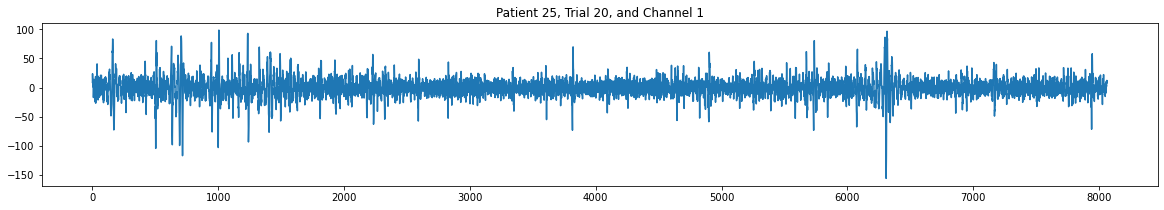

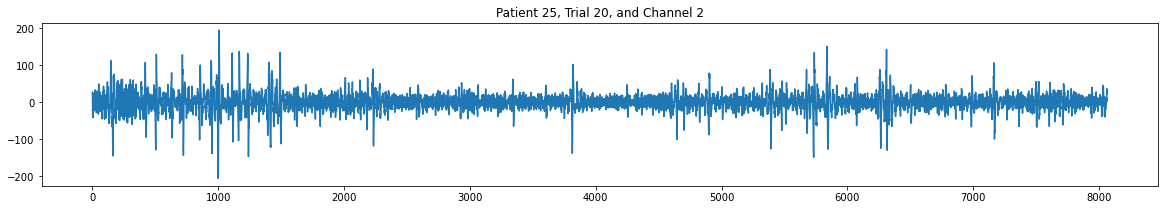

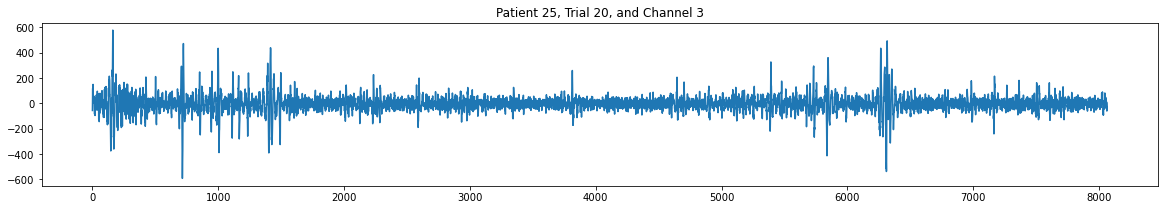

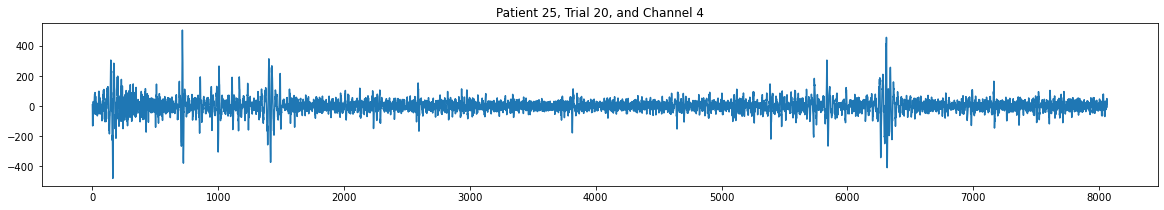

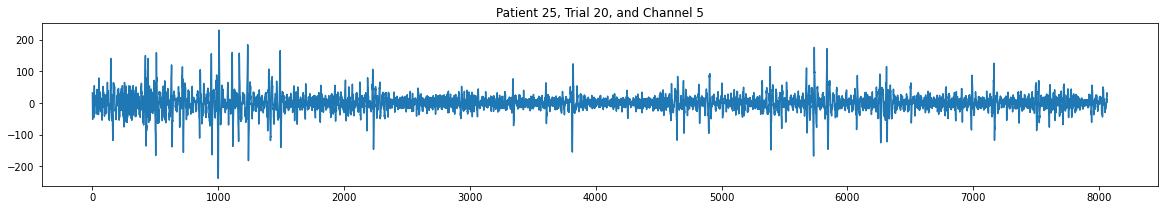

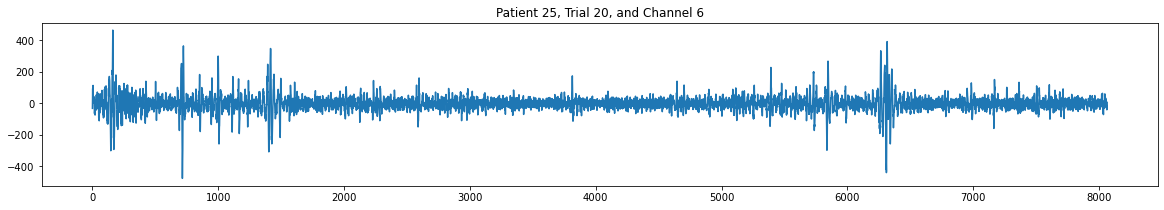

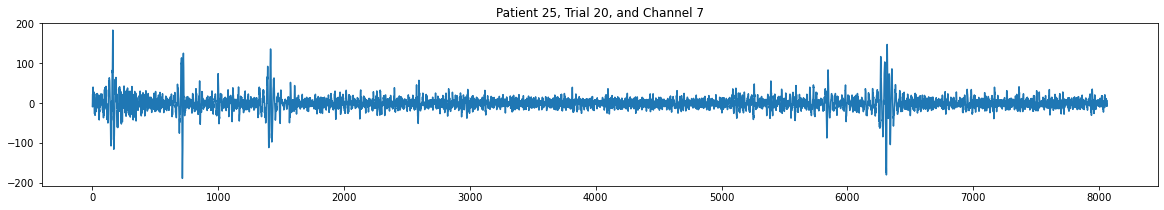

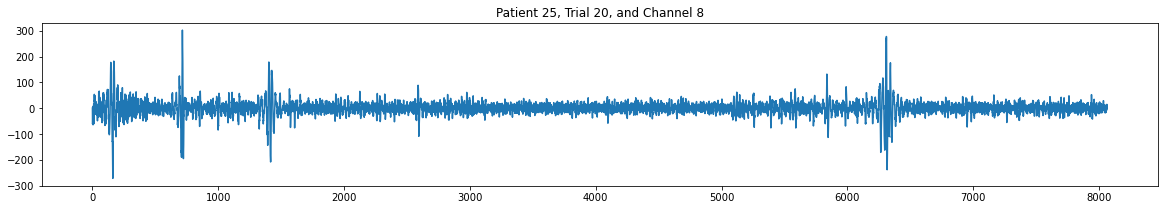

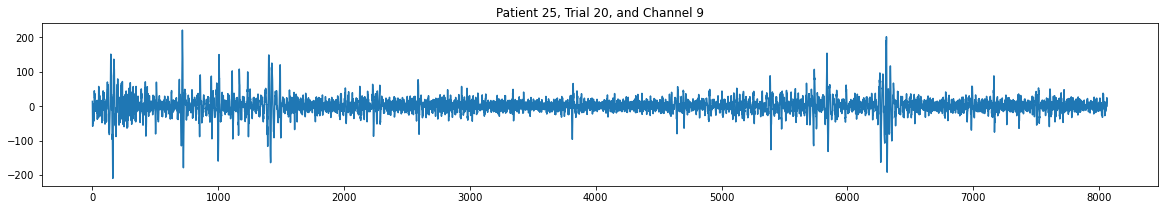

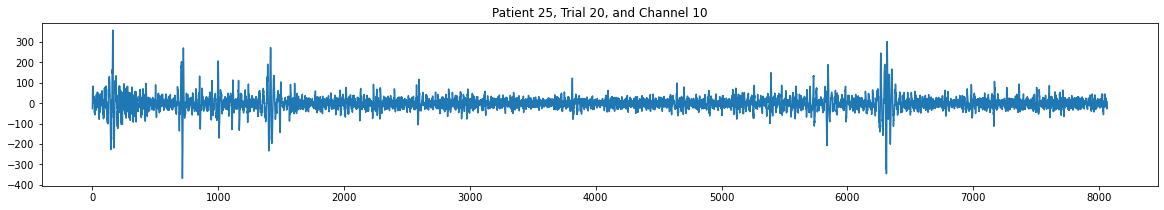

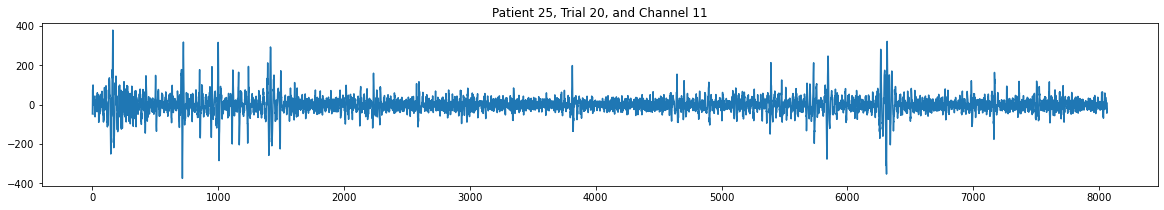

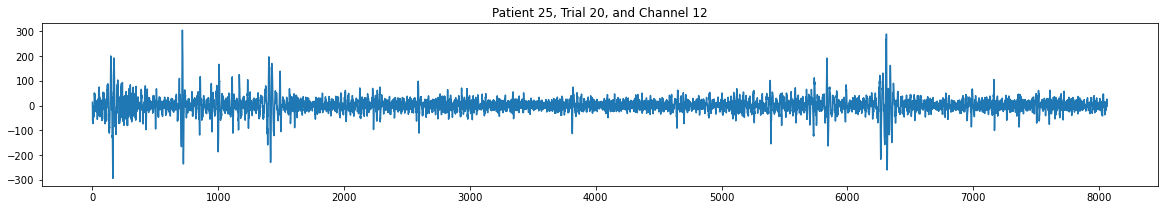

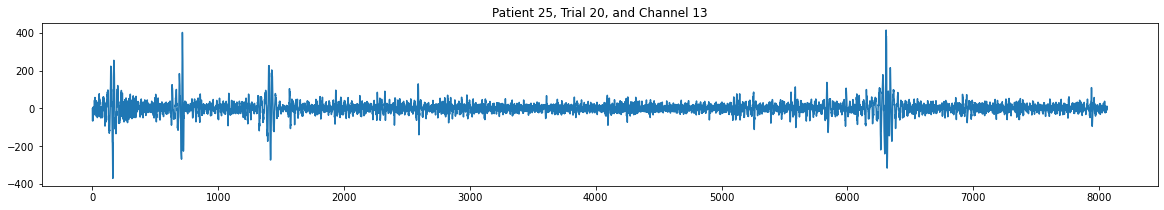

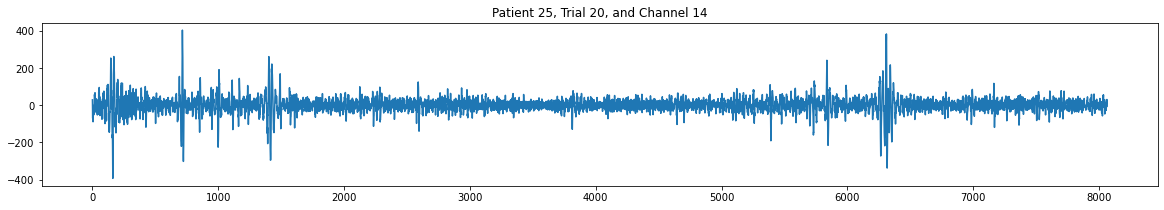

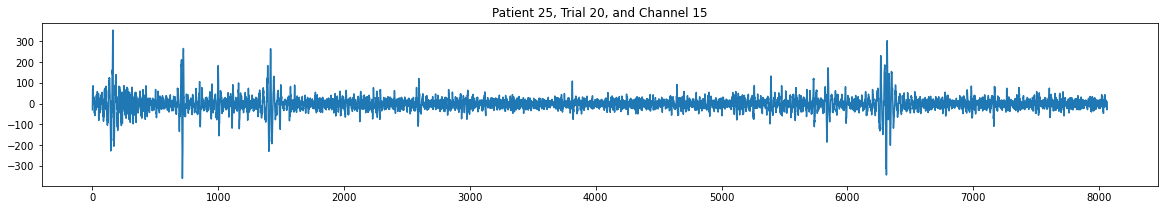

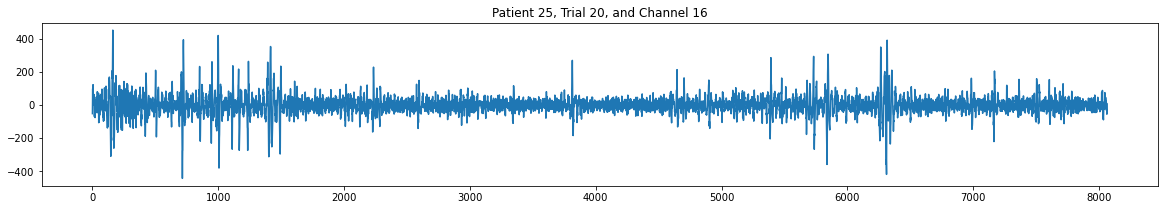

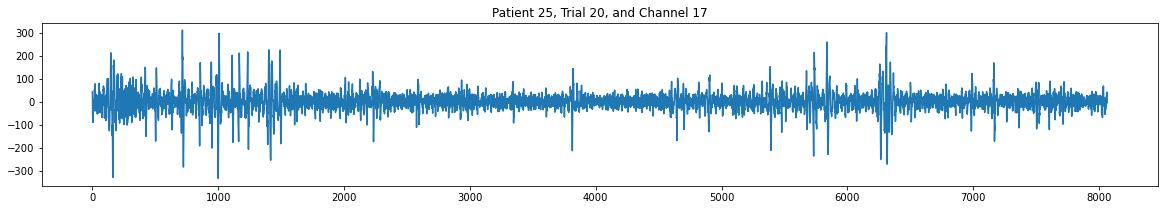

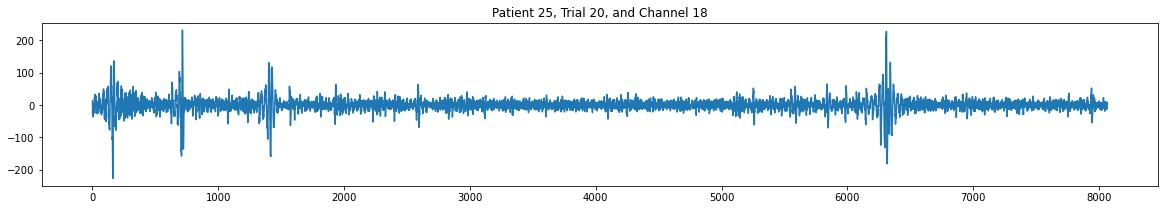

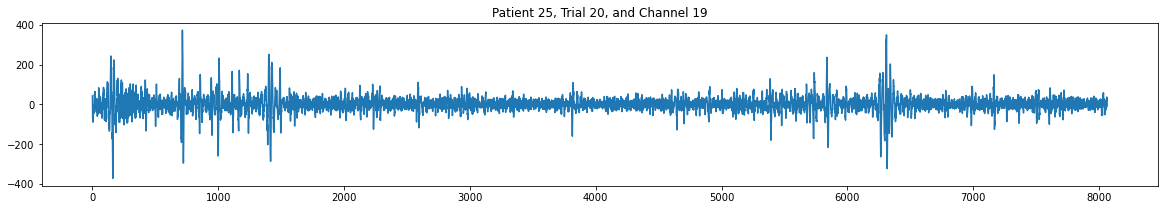

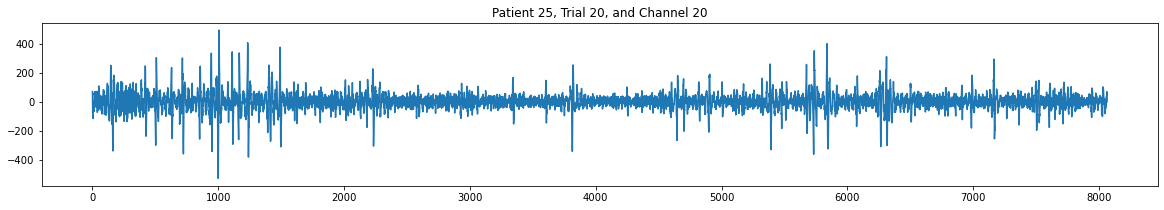

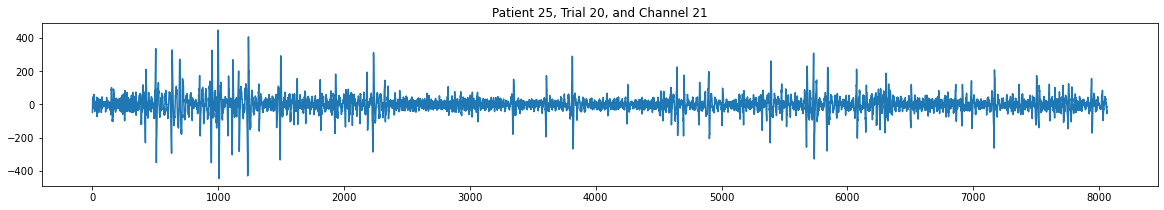

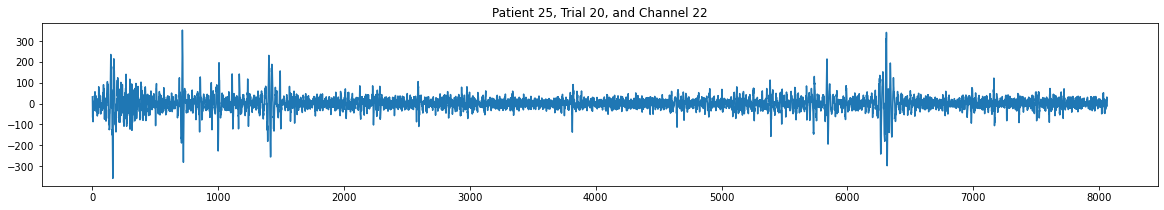

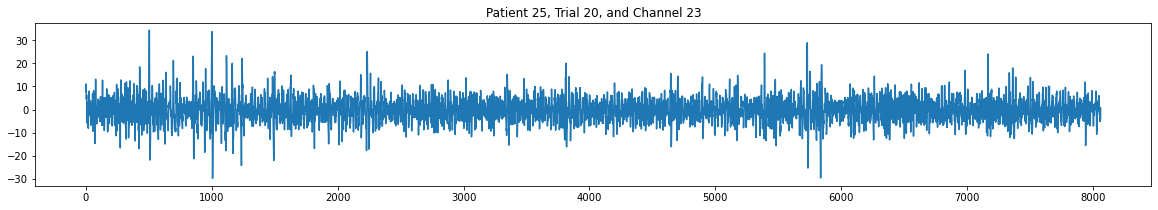

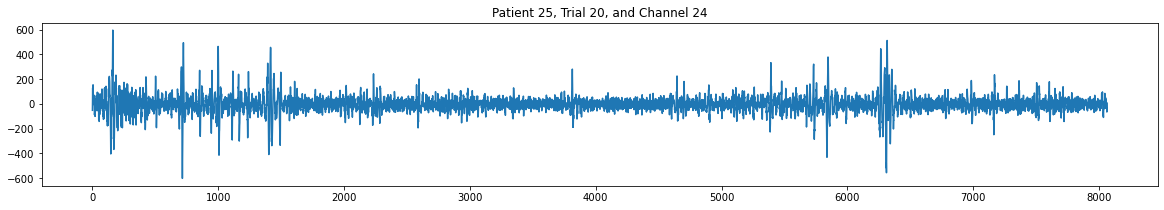

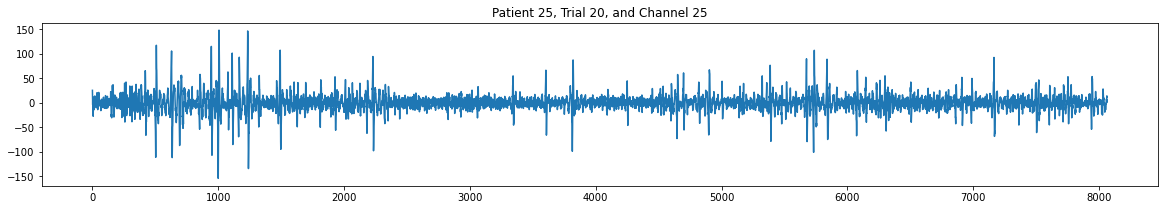

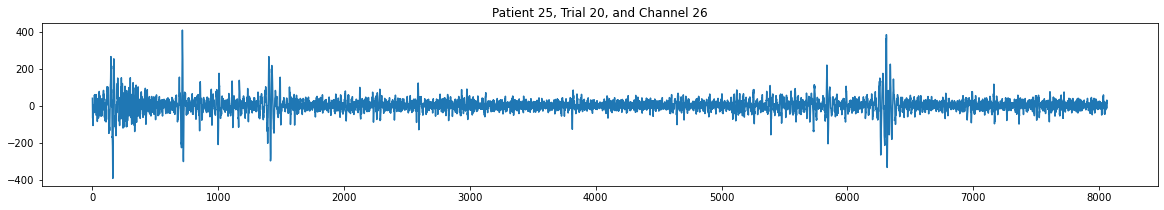

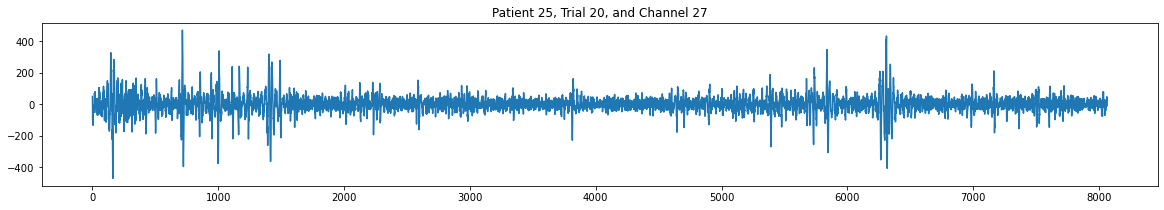

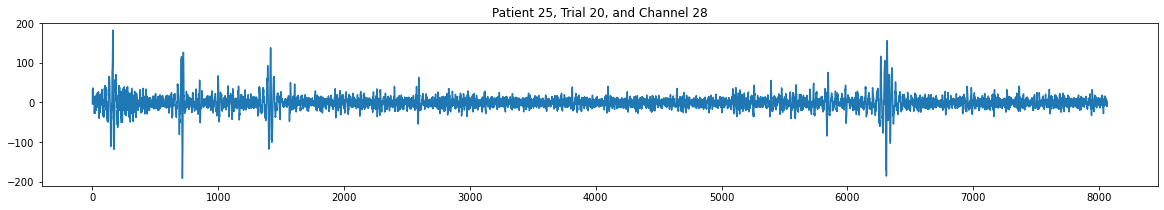

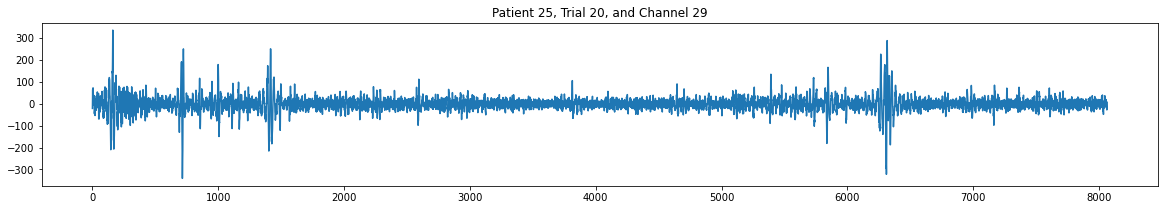

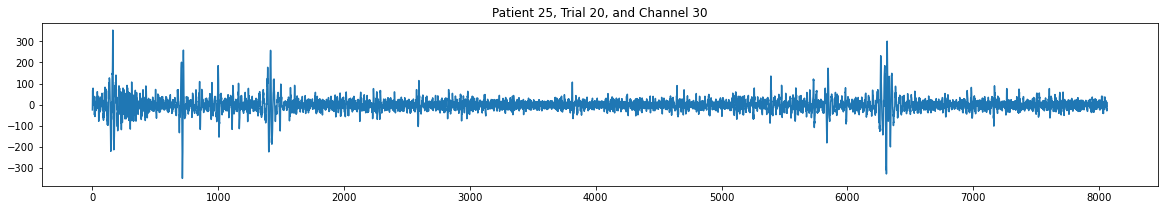

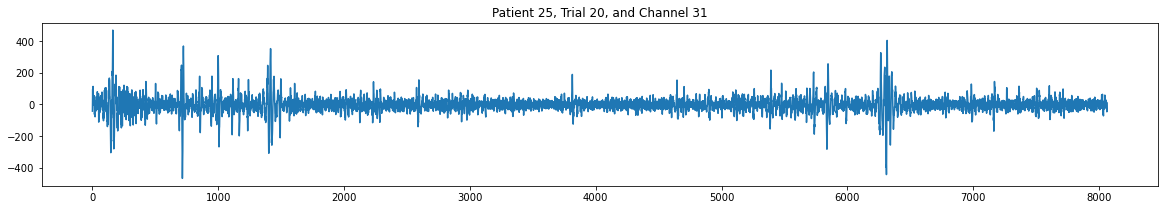

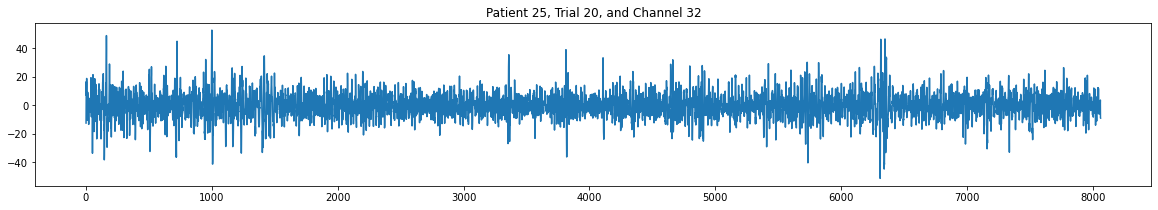

In [4]:
plt.rcParams["figure.figsize"] = (20,3)

patient_idx = 25 # between 1 and 32
test_trial  = 20 # between 1 and 40

for x in range(32):
    plt.plot(data[(patient_idx - 1) * 40 + test_trial - 1, x, :])
    plt.title('Patient {}, Trial {}, and Channel {}'.format(patient_idx, test_trial, x + 1))
    plt.show()

# 2) Feature extraction and selection

<blockquote>We now extract the features for each test trial. For each of the 32 EEG channel outputs, we compute statistical features, Hjorth parameters, fractal dimension, and band power for 5 frequency ranges. Note that most of the statistical features were not provided by the authors. We took the liberty to compute a few of our own, such as skew and EEG channel percentiles.</blockquote>
<blockquote>Finally, the authors limited their work to 14 relevant channels, without specifying how they selected these. We therefore compute features for all channels, and will let our feature selection algorithm choose a subset that is relevant for classification.</blockquote>

In [5]:
fs = 128 # Hz

# Define EEG bands
eeg_bands = {'Theta': [4, 8],
             'Low Alpha': [8, 10],
             'Alpha': [8, 12],
             'Beta': [12, 30],
             'Gamma':[30, 45]}

all_features = np.zeros((1280, 385))

for idx in trange(1280):
    test_features = [math.floor(idx / 40) + 1]
    
    for idy in range(32):        
        # Statistical features (9 total) (note that the ones selected here led to better performance)
        #test_features.append(np.median(data[idx, idy, :]))
        test_features.append(np.mean(data[idx, idy, :]))
        test_features.append(np.std(data[idx, idy, :]))
        #test_features.append(np.max(data[idx, idy, :]))
        #test_features.append(np.min(data[idx, idy, :]))
        test_features.append(scipy.stats.kurtosis(data[idx, idy, :]))
        #test_features.append(scipy.stats.skew(data[idx, idy, :]))
        #test_features.append(np.percentile(data[idx, idy, :], 25))
        #test_features.append(np.percentile(data[idx, idy, :], 50))
        #test_features.append(np.percentile(data[idx, idy, :], 75))

        # Hjorth parameters (3 total)
        test_features.append(eeglib.features.hjorthActivity(data[idx, idy, :]))
        test_features.append(eeglib.features.hjorthMobility(data[idx, idy, :]))
        test_features.append(eeglib.features.hjorthComplexity(data[idx, idy, :]))

        # Fractal dimension (1 total)
        test_features.append(eeglib.features.PFD(data[idx, idy, :]))

        # Band power features (5 total)
        for num, (name, band) in enumerate(eeg_bands.items()):
            [binpow], _ = pyeeg.bin_power(data[idx, idy, :], band, fs)
            test_features.append(binpow)
            
    test_features = np.asarray(test_features)
    
    all_features[idx, :] = test_features[:]

100%|██████████| 1280/1280 [04:15<00:00,  5.01it/s]


<blockquote>We now categorize data using $f(x)=1$ if $x\geq \mu + \frac{\sigma}{2}$, $-1$ if $x < \mu - \frac{\sigma}{2}$, and 0 otherwise for each subject's feature values.</blockquote>

In [6]:
for idx in trange(32):
    for idy in range(1, 12 * 32 + 1):
        temp_patient = all_features[idx*40: idx*40+40, idy]
        mean         = np.mean(temp_patient)
        std          = np.std(temp_patient)
        
        for test in range(40):
            temp_val = all_features[idx*40+test, idy]
            
            if   (temp_val >= mean + std / 2): 
                all_features[idx*40+test, idy] = 1
            elif (temp_val <  mean - std / 2): 
                all_features[idx*40+test, idy] = -1
            else: 
                all_features[idx*40+test, idy] = 0
                
print(all_features)

100%|██████████| 32/32 [00:00<00:00, 36.37it/s]

[[ 1.  0. -1. ... -1. -1. -1.]
 [ 1. -1.  0. ...  0. -1.  0.]
 [ 1.  1.  1. ...  1.  1.  0.]
 ...
 [32.  0. -1. ...  0.  0.  0.]
 [32.  1.  0. ...  0. -1.  1.]
 [32. -1. -1. ...  0. -1. -1.]]


<blockquote>We now convert our features to pandas data frames for input to the Minimum-Redundancy-Maximum-Relevance (MRMR) algorithm.</blockquote>

In [7]:
features = ['Mean', 'Std', 'Kurtosis', 'Hjorth1', 'Hjorth2', 'Hjorth3', 'FD', 'Theta', 
            'Low_Alpha', 'Alpha', 'Beta', 'Gamma']

header = []

for idx in range(1, 33):
    for feature in features:
        header.append("{}_{}".format(feature, idx))
        
X = pd.DataFrame(data=all_features[:, 1:], columns=header)
print(X)

      Mean_1  Std_1  Kurtosis_1  Hjorth1_1  Hjorth2_1  Hjorth3_1  FD_1  \
0        0.0   -1.0         0.0       -1.0        0.0       -1.0  -1.0   
1       -1.0    0.0         0.0        0.0       -1.0        1.0   0.0   
2        1.0    1.0         0.0        1.0        0.0        0.0   0.0   
3        0.0   -1.0         0.0       -1.0        0.0        1.0  -1.0   
4       -1.0   -1.0        -1.0       -1.0        1.0       -1.0  -1.0   
...      ...    ...         ...        ...        ...        ...   ...   
1275     0.0   -1.0         0.0       -1.0       -1.0        1.0  -1.0   
1276    -1.0    0.0         0.0        0.0       -1.0        1.0   0.0   
1277     0.0   -1.0         0.0       -1.0       -1.0        1.0  -1.0   
1278     1.0    0.0         1.0        0.0        1.0       -1.0   1.0   
1279    -1.0   -1.0         0.0       -1.0       -1.0        1.0  -1.0   

      Theta_1  Low_Alpha_1  Alpha_1  ...  Kurtosis_32  Hjorth1_32  Hjorth2_32  \
0         0.0         -1.0    

In [8]:
Y_valence = pd.DataFrame(data=labels[:, 1], columns=['Valence'])
Y_arousal = pd.DataFrame(data=labels[:, 2], columns=['Arousal'])
print(Y_valence)
print(Y_arousal)

      Valence
0           2
1           2
2           2
3           1
4           2
...       ...
1275        1
1276        0
1277        0
1278        1
1279        2

[1280 rows x 1 columns]
      Arousal
0           2
1           2
2           2
3           1
4           1
...       ...
1275        2
1276        1
1277        2
1278        2
1279        1

[1280 rows x 1 columns]


<blockquote>We now use the fully parallelized MRMR algorithm provided by PymRMRe to create a subset of features for future classification.</blockquote>

In [9]:
num_features_valence = 75 # Maximum is 12 * 32 = 384 for us
num_features_arousal = 75 # Maximum is 12 * 32 = 384 for us

solutions_valence = mrmr.mrmr_ensemble(features=X, targets=Y_valence, solution_length=num_features_valence, solution_count=1)
solutions_arousal = mrmr.mrmr_ensemble(features=X, targets=Y_arousal, solution_length=num_features_arousal, solution_count=1)

print("Valence:")
print(solutions_valence.iloc[0][0])
print("Arousal:")
print(solutions_arousal.iloc[0][0])

Valence:
['Beta_16', 'Kurtosis_2', 'Mean_11', 'Mean_17', 'Mean_14', 'FD_16', 'Mean_22', 'Mean_5', 'Hjorth3_11', 'Alpha_2', 'Mean_24', 'Mean_3', 'Mean_4', 'Mean_30', 'Mean_6', 'Mean_28', 'Kurtosis_6', 'Mean_20', 'Mean_9', 'Hjorth3_22', 'Mean_27', 'Low_Alpha_24', 'Mean_25', 'Gamma_1', 'Mean_21', 'Mean_7', 'Mean_13', 'Mean_31', 'Kurtosis_25', 'Mean_8', 'Mean_1', 'Alpha_22', 'FD_15', 'Mean_23', 'Mean_16', 'Hjorth3_24', 'Mean_32', 'Mean_18', 'Kurtosis_11', 'Gamma_22', 'Mean_12', 'Mean_10', 'Low_Alpha_15', 'Hjorth3_1', 'Mean_19', 'Kurtosis_15', 'Mean_15', 'Beta_24', 'FD_21', 'Mean_2', 'Hjorth3_25', 'Kurtosis_27', 'Mean_26', 'Hjorth1_16', 'Mean_29', 'Kurtosis_21', 'Hjorth3_18', 'Alpha_1', 'Gamma_30', 'Kurtosis_1', 'Hjorth3_16', 'FD_5', 'Kurtosis_26', 'Alpha_30', 'Beta_31', 'Hjorth3_32', 'Kurtosis_8', 'FD_14', 'Low_Alpha_16', 'Kurtosis_5', 'Hjorth3_15', 'Alpha_26', 'FD_26', 'Kurtosis_32', 'Beta_6']
Arousal:
['FD_11', 'Mean_12', 'Kurtosis_32', 'Std_5', 'Mean_25', 'Mean_16', 'Mean_6', 'Hjorth3_2

<blockquote>We now create new numpy arrays of features. We always keep the patient numbers in order to generate accuracies on a per-patient basis after shuffling input.</blockquote>

In [10]:
arousal_X = np.zeros((1280, num_features_arousal))
valence_X = np.zeros((1280, num_features_valence))

# Store patient number
patients = all_features[:, 0]

# Create set of features
arousal_X = X[solutions_arousal.iloc[0][0]].to_numpy()
valence_X = X[solutions_valence.iloc[0][0]].to_numpy()

# Now create targets
arousal_Y = np.zeros(1280)
valence_Y = np.zeros(1280)

arousal_Y = labels[:, 2]
valence_Y = labels[:, 1]

print("Arousal input: ")
print(arousal_X)
print("Arousal output: ")
print(arousal_Y)
print("Valence input: ")
print(valence_X)
print("Arousal output: ")
print(valence_Y)
print("The corresponding patients")
print(patients)

Arousal input: 
[[ 0.  0. -1. ...  0.  0.  0.]
 [-1.  0.  0. ...  1.  0.  0.]
 [-1. -1.  1. ...  0.  0.  0.]
 ...
 [-1.  0.  0. ...  1.  0. -1.]
 [ 0.  0.  0. ...  0.  0. -1.]
 [ 0.  0.  1. ...  1.  0.  0.]]
Arousal output: 
[2 2 2 ... 2 2 1]
Valence input: 
[[ 0.  0.  0. ...  0. -1. -1.]
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 1.  0. -1. ... -1.  1.  1.]
 ...
 [-1. -1.  0. ... -1.  0.  1.]
 [ 0. -1.  0. ...  0.  0. -1.]
 [ 1.  0.  0. ...  1.  1. -1.]]
Arousal output: 
[2 2 2 ... 0 1 2]
The corresponding patients
[ 1.  1.  1. ... 32. 32. 32.]


<blockquote>The data arrays are now ready for classification!</blockquote>

## 3) Training

<blockquote>We will use 8-fold cross validation, thus we need some preparation before training.</blockquote>

In [11]:
# given a trained classifier, test it on a validation set on a per-patient basis
# for each patient, we return -1 if the patient is not represented in the validation test,
# otherwise we give the accuracy of the predictions of its different stimui tests
# we also provide the total accuracy

def per_patient_result(clf, X, Y, patients) :
    Y_pred = clf.predict(X)
    result = - np.ones(33) # there are 32 patients, plus the total accuracy placed in first position
    result[0] = 0
    count_patient = np.zeros(32) # to keep the number of tests for each patient
    for i in range(Y.shape[0]) :
        patient = int(patients[i])
        
        if count_patient[patient - 1] == 0 : # if we haven't seen this patient yet, result[patient] = -1
            result[patient] = 0
            
        count_patient[patient - 1] += 1 # we have seen this patient one more time
        
        if Y_pred[i] == Y[i] : # if the prediction is correct, we update the count of correct predictions
            result[patient] += 1
            result[0] += 1
    # we now compute the accuracies
    result[0] /= Y.shape[0]
    for patient in range(1, 33) :
        if count_patient[patient - 1] != 0 :
            result[patient] /= count_patient[patient - 1]
    return result

In [12]:
# We predefine a function that will take the train and test sets and train an SVM according to this split
def one_trial(X_train, Y_train, X_test, Y_test, patient_test, gamma) :
    
    clf = SVC(C=1.5, kernel='rbf', gamma=gamma, decision_function_shape = 'ovo', tol=1e-10, verbose=False)
    clf.fit(X_train, Y_train)
    
    return per_patient_result(clf, X_test, Y_test, patient_test)

<blockquote>Now we are ready. We start with the arousal.</blockquote>

In [13]:
# we perform 8-fold cross validation
def cross_validation(X, Y, k = 8, gamma = 0.05): 
    
    accuracies = [] # in this list will be stored all accuracies for all different seeds and cross-validation
    
    for seed in range(3) :
        kf = KFold(n_splits=k, shuffle=True, random_state=seed)

        for train_index, test_index in kf.split(X):
    
            # this allows to split into train and test
            X_train, Y_train = X[train_index], Y[train_index]
            X_test, Y_test, patient_test = X[test_index], Y[test_index], patients[test_index]
    
            # now we use our functions and store the result
            accuracies.append(one_trial(X_train, Y_train, X_test, Y_test, patient_test, gamma))
    
    return np.array(accuracies)

In [14]:
# Now let's clarify the results
arousal_accuracies = cross_validation(arousal_X, arousal_Y)
arousal_mean = np.mean(arousal_accuracies, axis = 0)
arousal_std = np.std(arousal_accuracies, axis = 0)

valence_accuracies = cross_validation(valence_X, valence_Y)
valence_mean = np.mean(valence_accuracies, axis = 0)
valence_std = np.std(valence_accuracies)

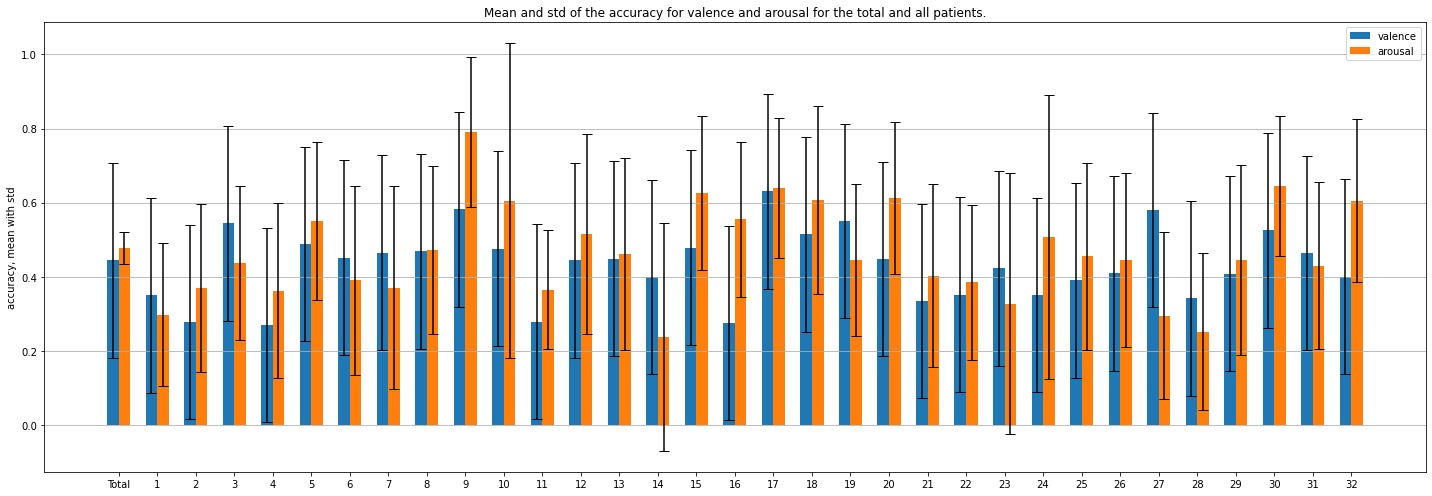

In [55]:
# Final plot
fig, ax = plt.subplots(figsize = (20,7))
x = np.arange(33)
width = 0.3
rects1 = ax.bar(x - width/2, valence_mean, width, yerr = valence_std, capsize = 5, label = 'valence')
rects2 = ax.bar(x + width/2, arousal_mean, width, yerr = arousal_std, capsize = 5, label = 'arousal')
xlabel = ["Total"]
for i in range(1,33) :
    xlabel.append(str(i))
ax.set_xticks(x)
ax.set_xticklabels(xlabel)
ax.set_ylabel("accuracy, mean with std")
ax.set_title("Mean and std of the accuracy for valence and arousal for the total and all patients.")
ax.legend()
ax.yaxis.grid(True)
fig.tight_layout()
plt.show()

<blockquote>We observe that we have a big variance. Our total mean accuracy is also far lower than the one of the article. Let's try to work on the number of selected features.</blockquote>

In [16]:
num_features = np.array([i for i in range(3, 99)]+[2*i for i in range(50, 90)])
total_mean_arousal = np.zeros_like(num_features, dtype = float)
total_std_arousal = np.zeros_like(num_features, dtype = float)
total_mean_valence = np.zeros_like(num_features, dtype = float)
total_std_valence = np.zeros_like(num_features, dtype = float)

# we proceed as before

for i in range(num_features.shape[0]) :
    num = num_features[i]
    
    # feature selection
    solutions_valence = mrmr.mrmr_ensemble(features=X, targets=Y_valence, solution_length=num, solution_count=1)
    solutions_arousal = mrmr.mrmr_ensemble(features=X, targets=Y_arousal, solution_length=num, solution_count=1)
    
    # recreate the arrays
    arousal_X = X[solutions_arousal.iloc[0][0]].to_numpy()
    valence_X = X[solutions_valence.iloc[0][0]].to_numpy()
    
    # we perform our tests
    arousal_accuracies = cross_validation(arousal_X, arousal_Y)
    total_mean_arousal[i] = np.mean(arousal_accuracies[:, 0])
    total_std_arousal[i] = np.std(arousal_accuracies[:, 0])
    
    valence_accuracies = cross_validation(valence_X, valence_Y)
    total_mean_valence[i] = np.mean(valence_accuracies[:, 0])
    total_std_valence[i] = np.std(valence_accuracies[:, 0])

In [17]:
best_num_arousal = np.argmax(total_mean_arousal)
best_num_valence = np.argmax(total_mean_valence)
print("The best accuracy for arousal is found for {} features, reaching {:.2f}%.".format(num_features[best_num_arousal], total_mean_arousal[best_num_arousal]*100))
print("The best accuracy for valence is found for {} features, reaching {:.2f}%.".format(num_features[best_num_valence], total_mean_valence[best_num_valence]*100))

The best accuracy for arousal is found for 85 features, reaching 48.54%.
The best accuracy for valence is found for 10 features, reaching 46.33%.


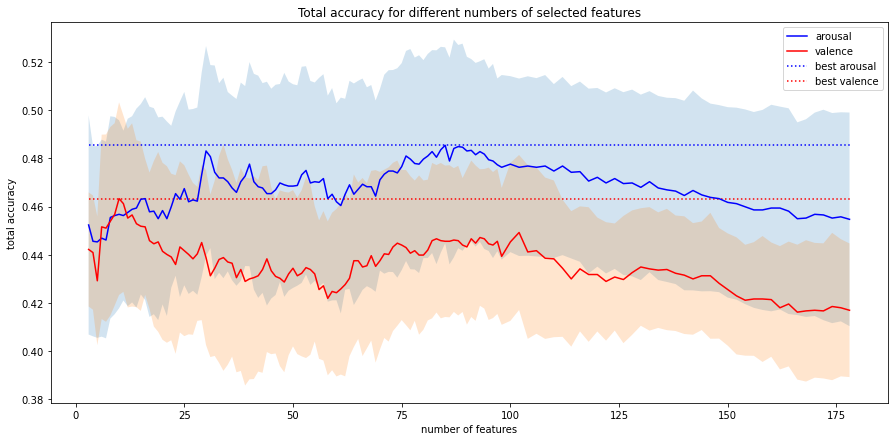

In [49]:
# Now plot

fig = plt.figure(figsize=(15,7))
plt.plot(num_features, total_mean_arousal, 'b', label = "arousal")
plt.fill_between(num_features, total_mean_arousal - total_std_arousal, total_mean_arousal + total_std_arousal, alpha=0.2)
plt.plot(num_features, total_mean_valence, 'r', label = "valence")
plt.fill_between(num_features, total_mean_valence - total_std_valence, total_mean_valence + total_std_valence, alpha=0.2)
plt.hlines(total_mean_arousal[best_num_arousal], 3, 178, 'b', linestyles='dotted', label="best arousal")
plt.hlines(total_mean_valence[best_num_valence], 3, 178, 'r', linestyles='dotted', label="best valence")
plt.xlabel("number of features")
plt.ylabel("total accuracy")
plt.title("Total accuracy for different numbers of selected features")
plt.legend()
plt.show()

It seems that no matter what is the number of features we select, we cannot achieve the results of the article. We found in [this article](https://www.hindawi.com/journals/mpe/2019/9875250/) the channels that are usually selected to train for such approaches. We assume that this may be the channels that the authors selected. Let's try with them.

## 4) With reduced channels

In [50]:
# restrain the number of channels

channels = np.array([1, 17, 2, 19, 20, 8, 24, 26, 28, 11, 16, 31, 15, 32]) 
 
# we use it to restrain the number of features
features_indices = np.zeros(12 * 14 + 1, dtype = int)
for i in range(14) :
    features_indices[i*12 + 1 : (i+1)*12 + 1] = np.arange((channels[i]-1)*12 + 1, channels[i]*12 + 1)

reduced_features = all_features[:, features_indices]

# we continue our process as before

header = []

for idx in range(1, 15):
    for feature in features:
        header.append("{}_{}".format(feature, idx))
        
reduced_X = pd.DataFrame(data=reduced_features[:, 1:], columns=header)

num_features = np.array([i for i in range(3, 99)]+[2*i for i in range(50, 84)]) # we can't

reduced_total_mean_arousal = np.zeros_like(num_features, dtype = float)
reduced_total_std_arousal = np.zeros_like(num_features, dtype = float)
reduced_total_mean_valence = np.zeros_like(num_features, dtype = float)
reduced_total_std_valence = np.zeros_like(num_features, dtype = float)


for i in range(num_features.shape[0]) :
    num = num_features[i]
    
    # feature selection
    reduced_solutions_valence = mrmr.mrmr_ensemble(features=reduced_X, targets=Y_valence, solution_length=num, solution_count=1)
    reduced_solutions_arousal = mrmr.mrmr_ensemble(features=reduced_X, targets=Y_arousal, solution_length=num, solution_count=1)
    
    # recreate the arrays
    reduced_arousal_X = reduced_X[reduced_solutions_arousal.iloc[0][0]].to_numpy()
    reduced_valence_X = reduced_X[reduced_solutions_valence.iloc[0][0]].to_numpy()
    
    # we perform our tests
    reduced_arousal_accuracies = cross_validation(reduced_arousal_X, arousal_Y)
    reduced_total_mean_arousal[i] = np.mean(reduced_arousal_accuracies[:, 0])
    reduced_total_std_arousal[i] = np.std(reduced_arousal_accuracies[:, 0])
    
    reduced_valence_accuracies = cross_validation(reduced_valence_X, valence_Y)
    reduced_total_mean_valence[i] = np.mean(reduced_valence_accuracies[:, 0])
    reduced_total_std_valence[i] = np.std(reduced_valence_accuracies[:, 0])

In [51]:
reduced_best_num_arousal = np.argmax(reduced_total_mean_arousal)
reduced_best_num_valence = np.argmax(reduced_total_mean_valence)
print("The best accuracy for arousal is found for {} features, reaching {:.2f}%.".format(num_features[reduced_best_num_arousal], reduced_total_mean_arousal[reduced_best_num_arousal]*100))
print("The best accuracy for valence is found for {} features, reaching {:.2f}%.".format(num_features[reduced_best_num_valence], reduced_total_mean_valence[reduced_best_num_valence]*100))

The best accuracy for arousal is found for 118 features, reaching 47.53%.
The best accuracy for valence is found for 6 features, reaching 46.12%.


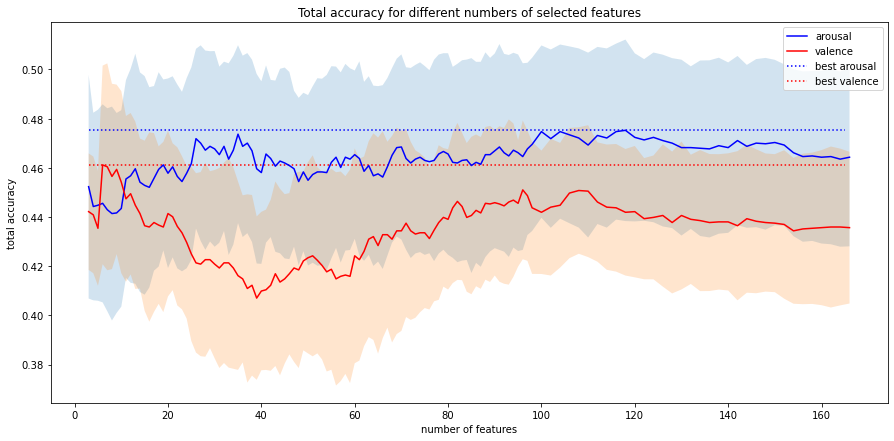

In [58]:
# Now plot

fig = plt.figure(figsize=(15,7))
plt.plot(num_features, reduced_total_mean_arousal, 'b', label = "arousal")
plt.fill_between(num_features, reduced_total_mean_arousal - reduced_total_std_arousal, reduced_total_mean_arousal + reduced_total_std_arousal, alpha=0.2)
plt.plot(num_features, reduced_total_mean_valence, 'r', label = "valence")
plt.fill_between(num_features, reduced_total_mean_valence - reduced_total_std_valence, reduced_total_mean_valence + reduced_total_std_valence, alpha=0.2)
plt.hlines(reduced_total_mean_arousal[reduced_best_num_arousal], 3, 165, 'b', linestyles='dotted', label="best arousal")
plt.hlines(reduced_total_mean_valence[reduced_best_num_valence], 3, 165, 'r', linestyles='dotted', label="best valence")
plt.xlabel("number of features")
plt.ylabel("total accuracy")
plt.title("Total accuracy for different numbers of selected features")
plt.legend()
plt.show()

The results are not better, in fact they seem to be a bit worse. Note that they even tend to require more features.

## 5) Impact of $\gamma$

Now let's see the impact of gamma on the results. For this purpose, we will reuse all features as in section 3, as this gave us the best results.

In [26]:
# let's start with the arousal
# we restrict the number of tests according to the previous results

num_features_ar = np.arange(75, 95)

In [28]:
# we test for gamma = 0.05, 0.1 and 0.5, note that 0.05 has already been done
mean_ar_05 = total_mean_arousal[num_features_ar - 3]
std_ar_05 = total_std_arousal[num_features_ar - 3]

mean_ar_1 = np.zeros_like(mean_ar_05)
std_ar_1 = np.zeros_like(mean_ar_05)

mean_ar_5 = np.zeros_like(mean_ar_05)
std_ar_5 = np.zeros_like(mean_ar_05)

# we proceed as before

for i in range(num_features_ar.shape[0]) :
    num = num_features_ar[i]
    
    # feature selection
    solutions_valence = mrmr.mrmr_ensemble(features=X, targets=Y_valence, solution_length=num, solution_count=1)
    
    # recreate the arrays
    arousal_X = X[solutions_arousal.iloc[0][0]].to_numpy()
    
    # gamma = 0.1
    arousal_accuracies = cross_validation(arousal_X, arousal_Y, gamma = 0.1)
    mean_ar_1[i] = np.mean(arousal_accuracies[:, 0])
    std_ar_1[i] = np.std(arousal_accuracies[:, 0])

    # gamma = 0.01
    arousal_accuracies = cross_validation(arousal_X, arousal_Y, gamma = 0.5)
    mean_ar_5[i] = np.mean(arousal_accuracies[:, 0])
    std_ar_5[i] = np.std(arousal_accuracies[:, 0])

In [30]:
best_num_ar_05 = np.argmax(mean_ar_05)
best_num_ar_5 = np.argmax(mean_ar_5)
best_num_ar_1 = np.argmax(mean_ar_1)
print("The best accuracies for arousal are found for :")
print("- gamma = 0.05 : {} features, reaching {:.2f}%.".format(num_features_ar[best_num_ar_05], mean_ar_05[best_num_ar_05]*100))
print("- gamma = 0.1 : {} features, reaching {:.2f}%.".format(num_features_ar[best_num_ar_1], mean_ar_1[best_num_ar_1]*100))
print("- gamma = 0.5 : {} features, reaching {:.2f}%.".format(num_features_ar[best_num_ar_5], mean_ar_5[best_num_ar_5]*100))

The best accuracies for arousal are found for :
- gamma = 0.05 : 85 features, reaching 48.54%.
- gamma = 0.1 : 75 features, reaching 45.23%.
- gamma = 0.5 : 75 features, reaching 45.23%.


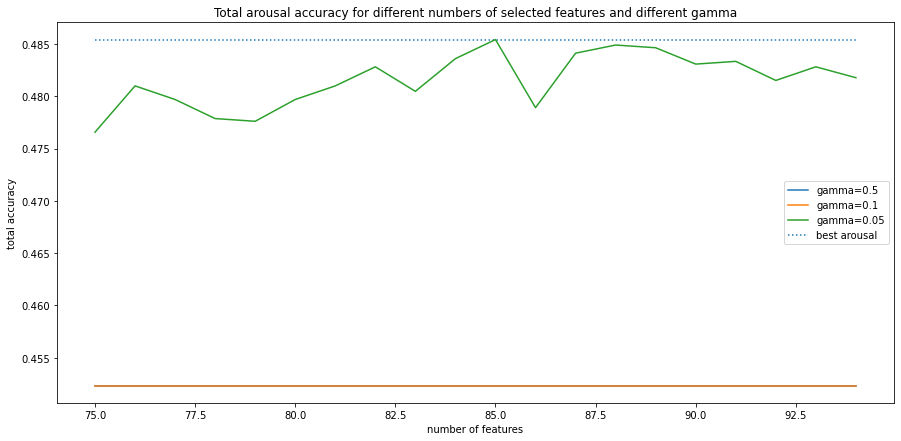

In [59]:
best_ar = max(mean_ar_05[best_num_ar_05], mean_ar_1[best_num_ar_1], mean_ar_5[best_num_ar_5])

fig = plt.figure(figsize=(15,7))
plt.plot(num_features_ar, mean_ar_5, label = "gamma=0.5")
#plt.fill_between(num_features_ar, mean_ar_5 - std_ar_5, mean_ar_5 + std_ar_5, alpha=0.2)
plt.plot(num_features_ar, mean_ar_1, label = "gamma=0.1")
#plt.fill_between(num_features_ar, mean_ar_1 - std_ar_1, mean_ar_1 + std_ar_1, alpha=0.2)
plt.plot(num_features_ar, mean_ar_05, label = "gamma=0.05")
#plt.fill_between(num_features_ar, mean_ar_05 - std_ar_05, mean_ar_05 + std_ar_05, alpha=0.2)
plt.hlines(best_ar, 75, 94, linestyles='dotted', label="best arousal")
plt.xlabel("number of features")
plt.ylabel("total accuracy")
plt.title("Total arousal accuracy for different numbers of selected features and different gamma")
plt.legend()
plt.show()

In [32]:
# now the valence

num_features_val = np.arange(3, 20)

In [60]:
mean_val_05 = total_mean_valence[num_features_val - 3]
std_val_05 = total_mean_valence[num_features_val - 3]

mean_val_1 = np.zeros_like(mean_val_05)
std_val_1 = np.zeros_like(mean_val_05)

mean_val_5 = np.zeros_like(mean_val_05)
std_val_5 = np.zeros_like(mean_val_05)

for i in range(num_features_val.shape[0]) :
    num = num_features_val[i]
    
    solutions_arousal = mrmr.mrmr_ensemble(features=X, targets=Y_arousal, solution_length=num, solution_count=1)
    valence_X = X[solutions_valence.iloc[0][0]].to_numpy()
    
    valence_accuracies = cross_validation(valence_X, valence_Y, gamma = 0.1)
    mean_val_1[i] = np.mean(valence_accuracies[:, 0])
    std_val_1[i] = np.std(valence_accuracies[:, 0])
    
    valence_accuracies = cross_validation(valence_X, valence_Y, gamma = 0.5)
    mean_val_5[i] = np.mean(valence_accuracies[:, 0])
    std_val_5[i] = np.std(valence_accuracies[:, 0])

In [61]:
best_num_val_05 = np.argmax(mean_val_05)
best_num_val_5 = np.argmax(mean_val_5)
best_num_val_1 = np.argmax(mean_val_1)
print("The best accuracy for valence is found for :")
print("- gamma = 0.05 : {} features, reaching {:.2f}%.".format(num_features_val[best_num_val_05], mean_val_05[best_num_val_05]*100))
print("- gamma = 0.1 : {} features, reaching {:.2f}%.".format(num_features_val[best_num_val_1], mean_val_1[best_num_val_1]*100))
print("- gamma = 0.5 : {} features, reaching {:.2f}%.".format(num_features_val[best_num_val_5], mean_val_5[best_num_val_5]*100))

The best accuracy for valence is found for :
- gamma = 0.05 : 10 features, reaching 46.33%.
- gamma = 0.1 : 3 features, reaching 41.33%.
- gamma = 0.5 : 3 features, reaching 40.16%.


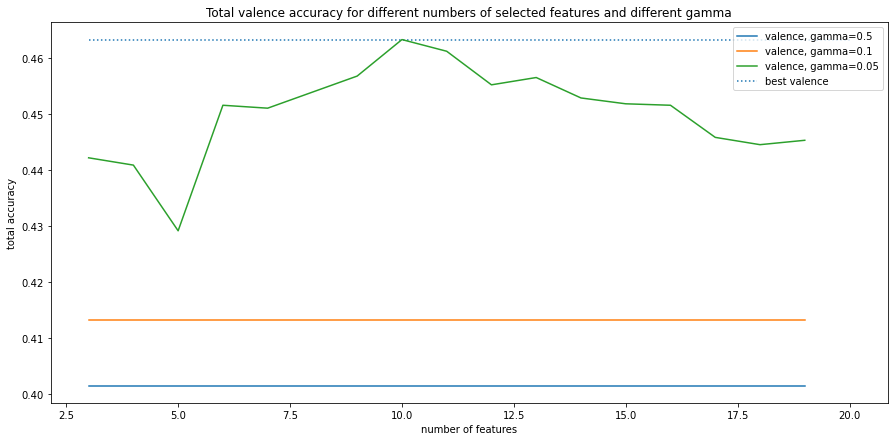

In [62]:
best_val = max(mean_val_05[best_num_val_05], mean_val_1[best_num_val_1], mean_val_5[best_num_val_5])

fig = plt.figure(figsize=(15,7))
plt.plot(num_features_val, mean_val_5, label = "valence, gamma=0.5")
#plt.fill_between(num_features_val, mean_val_5 - std_val_5, mean_val_5 + mean_val_5, alpha=0.2)
plt.plot(num_features_val, mean_val_1, label = "valence, gamma=0.1")
#plt.fill_between(num_features_val, mean_val_1 - std_val_1, mean_val_1 + mean_val_1, alpha=0.2)
plt.plot(num_features_val, mean_val_05, label = "valence, gamma=0.05")
#plt.fill_between(num_features_val, mean_val_05 - std_val_05, mean_val_05 + mean_val_05, alpha=0.2)
plt.hlines(best_val, 3, 20, linestyles='dotted', label="best valence")
plt.xlabel("number of features")
plt.ylabel("total accuracy")
plt.title("Total valence accuracy for different numbers of selected features and different gamma")
plt.legend()
plt.show()

Best results are found for $\gamma=0.05$. More comments can be found on the report.